In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
from scipy.signal import savgol_filter, detrend
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from tools.analysis import *

from boxsers.preprocessing import rubberband_baseline_cor

In [52]:
spectra = []
ids = []

for filename in os.listdir("data/Saenko/Saenko/"):
    name, extension = os.path.splitext(filename)
    if extension.lower() == ".csv":
        csv = pd.read_csv(os.path.join("data/Saenko/Saenko/", filename), header=None)
        domain = csv.iloc[1:, 0].to_numpy().astype(np.float32)
        spectra.append(csv.iloc[1:, 1].to_numpy())
        ids.append(int(name.split('-')[1]))

spectra = pd.DataFrame(spectra, columns=domain, index=ids)
spectra

,400.163513,400.645599,401.127686,401.609802,402.091888,402.574097,403.056213,403.538300,404.020386,404.502594,...,3995.849121,3996.331055,3996.812988,3997.294922,3997.777100,3998.259033,3998.740967,3999.224121,3999.706055,4000.187988
10,0.290876,0.287384,0.282910,0.277133,0.269982,0.261934,0.253944,0.247124,0.242393,0.240260,...,0.008766,0.008771,0.008776,0.008780,0.008784,0.008786,0.008786,0.008784,0.008779,0.008771
100,0.269848,0.271143,0.272863,0.274614,0.276045,0.277044,0.277821,0.278775,0.280253,0.282331,...,0.010612,0.010604,0.010587,0.010566,0.010542,0.010518,0.010498,0.010484,0.010478,0.010479
101,0.284154,0.284299,0.285566,0.287428,0.289343,0.291023,0.292534,0.294187,0.296272,0.298805,...,0.009802,0.009808,0.009806,0.009795,0.009778,0.009756,0.009734,0.009718,0.009712,0.009715
102,0.324013,0.328069,0.331918,0.334630,0.335661,0.335183,0.334053,0.333418,0.334155,0.336462,...,0.011390,0.011361,0.011332,0.011306,0.011285,0.011270,0.011260,0.011256,0.011256,0.011260
103,0.184576,0.185417,0.186708,0.187974,0.188820,0.189097,0.188955,0.188749,0.188826,0.189355,...,0.009413,0.009395,0.009376,0.009361,0.009350,0.009345,0.009346,0.009350,0.009356,0.009362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.232703,0.235006,0.237765,0.240452,0.242631,0.244127,0.245070,0.245787,0.246580,0.247551,...,0.009036,0.009033,0.009025,0.009013,0.008998,0.008981,0.008966,0.008954,0.008947,0.008945
96,0.187118,0.184371,0.183669,0.184776,0.187351,0.191008,0.195388,0.200154,0.204942,0.209283,...,0.009824,0.009806,0.009787,0.009767,0.009747,0.009727,0.009710,0.009696,0.009689,0.009689
97,0.272800,0.276185,0.279601,0.282444,0.284180,0.284599,0.283925,0.282675,0.281372,0.280307,...,0.010499,0.010483,0.010463,0.010442,0.010422,0.010403,0.010388,0.010379,0.010375,0.010379
98,0.268240,0.270295,0.273169,0.276142,0.278616,0.280340,0.281479,0.282462,0.283695,0.285311,...,0.010565,0.010549,0.010528,0.010506,0.010486,0.010468,0.010457,0.010452,0.010453,0.010460


<Axes: >

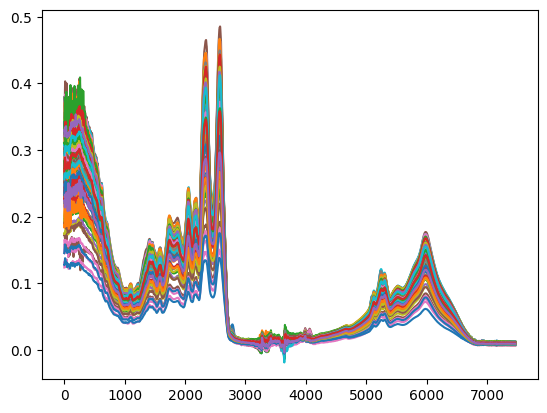

In [45]:
spectra.T.plot(legend=False)

In [104]:
id_df = pd.read_excel("data/Зразки-1.xlsx")
id_df.iloc[:, 2] = id_df.iloc[:, 2].str.rstrip('.')
id_df = id_df.iloc[:, :3]
id_df = id_df.rename(columns={
    "Номер": "Number",
    "Код": "ID",
    "Прізвище ": "Full Name"
})
id_df

,Number,ID,Full Name
0,1,SAE,Ніколєнко В.В
1,2,SAE,Толочний Ю.В
2,3,SAE,Коновальчук І.Ф
3,4,SAE,Шиян О.П
4,5,SAE,Манукян Г.М
...,...,...,...
193,194,SAE,Панченко О.В
194,195,SAE,Давиденко М.А
195,196,SAE,Ващук Н.В
196,197,SAE,Городинський О.М


In [107]:
hbs = pd.read_excel("data/Hb_HbA1c.xlsx").iloc[:, 2:]
hbs['name'] = hbs['Прізвище'] + " " + hbs["Ім'я"].str[0] + "." + hbs['По-батькові'].str[0]
hbs = hbs.rename(columns={
    'Глікований гемоглобін,%': 'HbA1c',
    'Еритроцити': 'Erythrocytes',
    'Гемоглобін': 'Hb',
    'Прізвище': 'Surname',
    'Ім\'я': 'Name',
    'По-батькові': 'Patronymic',
    'name': 'Full Name'
})
hbs['HbA1c'] = hbs['HbA1c'].apply(pd.to_numeric, errors='coerce')
hbs['Erythrocytes'] = hbs['Erythrocytes'].apply(pd.to_numeric, errors='coerce')
hbs['Hb'] = hbs['Hb'].apply(pd.to_numeric, errors='coerce')
hbs = hbs.dropna(axis=0)
hbs = hbs.iloc[:, [0, 1, 2, 6]]
hbs

,HbA1c,Erythrocytes,Hb,Full Name
0,7.70,4.85,168.0,Мариношенко С.А
1,8.10,5.10,149.0,Середняк П.М
2,7.88,4.50,136.0,Сухінін В.В
3,8.60,4.00,112.0,Буркевич М.Б
4,6.30,5.40,163.0,Раб О.В
...,...,...,...,...
509,5.30,5.40,164.0,Голованьов В.М
510,5.60,5.10,153.0,Гальченко З.О
511,6.10,5.00,150.0,Шкурат В.М
512,5.70,4.50,137.0,Коломієць С.О


In [112]:
merged_df = pd.merge(hbs, id_df, on='Full Name').drop_duplicates('Full Name')

In [122]:
merged_df = merged_df[merged_df['Number'].isin(ids)]
merged_df.index = merged_df['Number']
merged_df.index.name = None
merged_df

,HbA1c,Erythrocytes,Hb,Full Name,Number,ID
13,8.6,4.0,112.0,Буркевич М.Б,13,SAE
15,10.3,4.9,153.0,Козленко В.Я,15,SAE
80,5.9,5.2,153.0,Радченко В.С,80,SAE
22,6.5,3.6,106.0,Ковальчук Р.Й,22,SAE
77,8.8,5.0,165.0,Білокур В.В,77,SAE
...,...,...,...,...,...,...
156,5.7,4.5,140.0,Бойчук Л.П,156,SAE
158,5.9,4.5,136.0,Ковальчук Н.М,158,SAE
131,5.4,4.9,152.0,Овчаренко В.В,131,SAE
129,5.9,4.5,127.0,Поліщук О.О,129,SAE


In [130]:
df = pd.concat((spectra, merged_df.iloc[:, :3]), axis=1).dropna()
df

,400.163513,400.645599,401.127686,401.609802,402.091888,402.574097,403.056213,403.5383,404.020386,404.502594,...,3997.294922,3997.7771,3998.259033,3998.740967,3999.224121,3999.706055,4000.187988,HbA1c,Erythrocytes,Hb
10,0.290876,0.287384,0.282910,0.277133,0.269982,0.261934,0.253944,0.247124,0.242393,0.240260,...,0.008780,0.008784,0.008786,0.008786,0.008784,0.008779,0.008771,9.1,4.7,135.0
101,0.284154,0.284299,0.285566,0.287428,0.289343,0.291023,0.292534,0.294187,0.296272,0.298805,...,0.009795,0.009778,0.009756,0.009734,0.009718,0.009712,0.009715,5.6,4.9,151.0
102,0.324013,0.328069,0.331918,0.334630,0.335661,0.335183,0.334053,0.333418,0.334155,0.336462,...,0.011306,0.011285,0.011270,0.011260,0.011256,0.011256,0.011260,5.3,5.3,179.0
103,0.184576,0.185417,0.186708,0.187974,0.188820,0.189097,0.188955,0.188749,0.188826,0.189355,...,0.009361,0.009350,0.009345,0.009346,0.009350,0.009356,0.009362,9.6,4.8,157.0
104,0.223262,0.225337,0.227945,0.230671,0.233155,0.235231,0.237008,0.238779,0.240839,0.243284,...,0.011399,0.011376,0.011358,0.011345,0.011340,0.011342,0.011350,9.2,4.5,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.292312,0.293791,0.295307,0.296455,0.296984,0.296948,0.296711,0.296749,0.297397,0.298669,...,0.010497,0.010497,0.010500,0.010504,0.010506,0.010507,0.010506,5.4,4.3,137.0
95,0.232703,0.235006,0.237765,0.240452,0.242631,0.244127,0.245070,0.245787,0.246580,0.247551,...,0.009013,0.008998,0.008981,0.008966,0.008954,0.008947,0.008945,5.5,5.1,152.0
96,0.187118,0.184371,0.183669,0.184776,0.187351,0.191008,0.195388,0.200154,0.204942,0.209283,...,0.009767,0.009747,0.009727,0.009710,0.009696,0.009689,0.009689,7.4,4.8,158.0
98,0.268240,0.270295,0.273169,0.276142,0.278616,0.280340,0.281479,0.282462,0.283695,0.285311,...,0.010506,0.010486,0.010468,0.010457,0.010452,0.010453,0.010460,6.9,5.7,179.0
